# Pre-training

- 学習データの準備
- 言語モデルとは
- ニューラルネットワークを使用しない手法(uni-gram, bi-gram)
- Transformer 以前のニューラルネットワークを使用した言語モデル
  - MLP
  - RNN
- Transformer を使用した言語モデル
  - Self-Attention と Feedforward Network の実装、並列化
  - GPT-2 の実装

プログラミングの解説・エラー解消や用語の解説 GPT  
https://chatgpt.com/g/g-H1Baw636t-mlxian-bei


## 学習データの準備

ChatGPT のような大規模言語モデルの学習には文書データを大量に集める必要があります。  
データの集め方によってモデルの性能が大きく左右されるので、学習データの準備は重要な工程です。以下に参考になりそうな論文を載せておきます。

- [Dolma: an Open Corpus of Three Trillion Tokens for Language Model Pretraining Research](https://arxiv.org/abs/2402.00159)
- [FineWeb: decanting the web for the finest text data at scale](https://huggingface.co/spaces/HuggingFaceFW/blogpost-fineweb-v1)
- [Data Mixing Laws: Optimizing Data Mixtures by Predicting Language Modeling Performance](https://arxiv.org/abs/2403.16952)
- [To Code, or Not To Code? Exploring Impact of Code in Pre-training](https://arxiv.org/abs/2408.10914)
- [Instruction Pre-Training: Language Models are Supervised Multitask Learners](https://arxiv.org/abs/2406.14491)
- [Textbooks Are All You Need](https://arxiv.org/abs/2306.11644)
- [Physics of Language Models: Part 3.1, Knowledge Storage and Extraction](https://arxiv.org/abs/2309.14316)
- [松尾・岩澤研究室で開催した LLM 勉強会での発表資料](https://docs.google.com/presentation/d/14SeP11PcgmNcl93Xt0ziSynxdrOVd2WM/edit?usp=sharing&ouid=101802221278095300433&rtpof=true&sd=true)

今回は[LLM-jp という団体](https://llm-jp.nii.ac.jp/)が整備したコーパスを利用します。

- https://gitlab.llm-jp.nii.ac.jp/datasets/llm-jp-corpus-v2


```
!wget --no-check-certificate https://gitlab.llm-jp.nii.ac.jp/datasets/llm-jp-corpus-v2/-/raw/main/ja/ja_wiki/train_9.jsonl.gz
!wget --no-check-certificate https://gitlab.llm-jp.nii.ac.jp/datasets/llm-jp-corpus-v2/-/raw/main/ja/ja_wiki/validation_0.jsonl.gz
```


In [2]:
import gzip
import json
from pprint import pprint

mini_train_data_file_num = 1000
mini_train_data_text = ""
file_count = 0
with gzip.open("./train_9.jsonl.gz", "rt", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        mini_train_data_text += data["text"] + "\n"
        file_count += 1
        if file_count == mini_train_data_file_num:
            break

print(data.keys())
print(data["text"][:100])
print(data["meta"])

dict_keys(['text', 'meta'])
チリコシーは、アメリカ合衆国オハイオ州中央部南ロス郡の都市であり、同郡の郡庁所在地である。コロンバス大都市圏に属している。

2010年の国勢調査では人口21,901 人だった。ロス郡では唯一の都市で
{'id': '2973866', 'title': 'チリコシー (オハイオ州)', 'url': 'https://ja.wikipedia.org/wiki/%E3%83%81%E3%83%AA%E3%82%B3%E3%82%B7%E3%83%BC%20%28%E3%82%AA%E3%83%8F%E3%82%A4%E3%82%AA%E5%B7%9E%29'}


In [3]:
val_data_file_num = 1
val_data_text = ""
file_count = 0
with gzip.open("validation_0.jsonl.gz", "rt", encoding="utf-8") as f:
    for line in f:
        # 各行をJSONとして読み込む
        data = json.loads(line)
        val_data_text += data["text"] + "\n"
        file_count += 1
        if file_count == val_data_file_num:
            break
print(data.keys())
print(data["text"][:100])
print(data["meta"])

dict_keys(['text', 'meta'])
梶原 一騎（かじわら いっき、1936年9月4日 - 1987年1月21日）は、日本の漫画原作者、小説家、映画プロデューサー。本名は高森 朝樹（たかもり あさき）。高森 朝雄（たかもり あさお）の筆名
{'id': '506', 'title': '梶原一騎', 'url': 'https://ja.wikipedia.org/wiki/%E6%A2%B6%E5%8E%9F%E4%B8%80%E9%A8%8E'}


## 言語モデルとは

大規模言語モデルの"言語モデル"とは、単語列の出現確率をモデル化したものです。  
確率を計算できるので、与えられた文章がよく見る文章(確率が高い)なのか、変な文章なのか(確率が低い)を判断することができたり、新たに文章を生成(確率に従ってくじ引きをする)することができます。
より良い言語モデルの開発のためには、データとどのように確率をモデル化するかのデザインが重要です。

### データについて

言語モデルはデータを元に学習するため、そのデータに有益な情報(例えば日本の歴史や法律に関する文章)が含まれていないと、単語自身の理解や単語同士の関係性を学習することができません。  
人間が本を読んだり、人との会話を通じて新しい知識を得たり、良い文章の書き方を学んだりするように、言語モデルもデータを通じて学習します。

### モデル化について

データを得たとしても、どのように確率をモデル化するかのデザインがうまくいかないと、良い言語モデルは作れません。

- データ中の文字を数え上げて前の 1 単語から次の 1 単語を予測するモデル
- ニューラルネットワークの一種である MLP を用いて、前の数単語から次の 1 単語を予測するモデル
- Transformer を用いて、より長い文脈を考慮して次の単語を予測するモデル

を開発します。


## ニューラルネットワークを使用しない、数え上げによる手法(uni-gram, bi-gram)の言語モデル


### n-gram 言語モデル

$P\left(w_1, \ldots, w_m\right)=\prod_{i=1}^{i=m} P\left(w_i \mid w_1, \ldots, w_{i-1}\right) \approx \prod_{i=1}^{i=m} P\left(w_i \mid w_{i-n}, \ldots, w_{i-1}\right)$

#### uni-gram モデル

$P\left(w_1, \ldots, w_m\right) \approx \prod_{i=1}^{i=m} P(w_i)$

#### bi-gram モデル

$P\left(w_1, \ldots, w_m\right)\approx \prod_{i=1}^{i=m} P\left(w_i \mid w_{i-1}\right)$

$P\left(w_{i} \mid w_{i-1}\right)=\frac{\operatorname{count}\left(w_{i}, w_{i-1}\right)}{\operatorname{count}\left(w_{i}\right)}$


In [4]:
print(mini_train_data_text[:100])
print("------------------------")
print("全体の文字数: ", len(mini_train_data_text))
print("文字の種類: ", len(set(mini_train_data_text)))

『勝つか死ぬか』はHBO(日本ではスター・チャンネルが放送)のファンタジー・ドラマ・シリーズである『ゲーム・オブ・スローンズ』の第1章『七王国戦記』の第7話である。プロデューサーでもあるデイヴィッド・
------------------------
全体の文字数:  1569582
文字の種類:  3807


In [5]:
character_count = {}
for character in mini_train_data_text:
    character_count[character] = character_count.get(character, 0) + 1
# 出現頻度の高い文字を上位5個表示
print("出現頻度の高い文字")
print(sorted(character_count.items(), key=lambda kv: -kv[1])[:5])

# 過去の情報を考慮しないuni-gramモデル
print()
total_count = sum(character_count.values())
ch_0 = "日"
ch_1 = "本"
ch_2 = "曜"
print(
    f"'{ch_0}'の確率 = '{ch_0}'の出現回数 ÷ 全体の文字数 =  {character_count[ch_0]} ÷ {total_count} = {character_count[ch_0] / total_count}"
)
print(
    f"'{ch_0 + ch_1}'の確率 = '{ch_0}'の確率 x '{ch_1}'の確率 = {character_count[ch_0] / total_count} x {character_count[ch_1] / total_count} = {character_count[ch_0] * character_count[ch_1] / total_count ** 2}"
)
print(
    f"'{ch_0 + ch_2}'の確率 = '{ch_0}'の確率 x '{ch_2}'の確率 = {character_count[ch_0] / total_count} x {character_count[ch_2] / total_count} = {character_count[ch_0] * character_count[ch_2] / total_count ** 2}"
)

出現頻度の高い文字
[(' ', 53441), ('\n', 44189), ('の', 38675), ('、', 30453), ('ー', 29588)]

'日'の確率 = '日'の出現回数 ÷ 全体の文字数 =  7361 ÷ 1569582 = 0.004689783649404746
'日本'の確率 = '日'の確率 x '本'の確率 = 0.004689783649404746 x 0.001984604818352912 = 9.307367227641361e-06
'日曜'の確率 = '日'の確率 x '曜'の確率 = 0.004689783649404746 x 0.00018093989355127672 = 8.485689543018127e-07


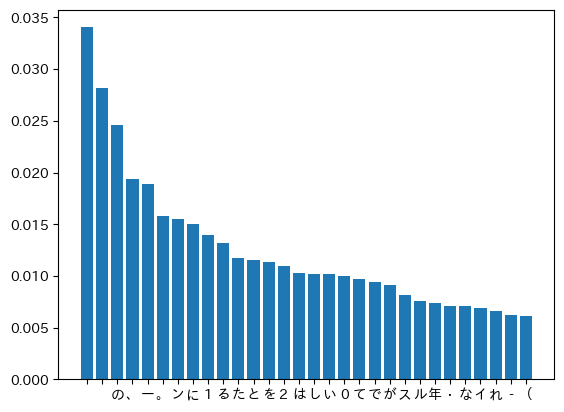

In [6]:
# 出現確率の可視化
import matplotlib.pyplot as plt
import japanize_matplotlib

total_count = sum(character_count.values())
# 上位30文字の出現頻度を取る
top_k = 30
top_k_key = sorted(character_count.keys(), key=lambda k: -character_count[k])[:top_k]
top_k_value = [character_count[k] for k in top_k_key]
top_k_probability = [v / total_count for v in top_k_value]

# x軸に文字、y軸に出現頻度を取る
plt.bar(top_k_key, top_k_probability)
plt.show()

In [7]:
# 生成
# greedy decoding
max_tokens = 20
generated_text = "『勝つか"
for _ in range(max_tokens):
    next_char = max(
        character_count,
        key=lambda k: character_count[k],
    )  # 最も出現頻度が高い文字を選択, greedy decoding
    print(repr(next_char))
    generated_text += next_char

print(repr(generated_text))

' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
' '
'『勝つか                    '


In [8]:
import random

random.seed(1234)
max_tokens = 30
top_p = 0.9
generated_text = "『勝つか"

for _ in range(max_tokens):
    sorted_character_count = sorted(character_count.items(), key=lambda kv: -kv[1])
    cumulative_probability = 0.0
    vocab = []
    vocab_count = []
    vocab_total_count = 0
    for character, count in sorted_character_count:
        cumulative_probability += count / total_count
        if cumulative_probability > top_p:
            break
        vocab.append(character)
        vocab_count.append(count)
        vocab_total_count += count
    probability = [count / vocab_total_count for count in vocab_count]
    next_char = random.choices(vocab, probability)[0]
    print(repr(next_char))
    generated_text += next_char

print(repr(generated_text))

'決'
'ア'
' '
'持'
'J'
'ん'
'コ'
'の'
'部'
'と'
' '
'ど'
'が'
't'
'く'
'。'
'に'
'、'
' '
'り'
'〜'
'\n'
'」'
'っ'
'6'
'の'
'a'
'2'
'こ'
'プ'
'『勝つか決ア 持Jんコの部と どがtく。に、 り〜\n」っ6のa2こプ'


### Tokenizer

Tokenizer の設計も重要です、以下に参考となるリンクを載せておきます。

- [Let's build the GPT Tokenizer](https://www.youtube.com/watch?v=zduSFxRajkE)
- [Scaling Laws with Vocabulary: Larger Models Deserve Larger Vocabularies](https://arxiv.org/abs/2407.13623)
- [ByT5: Towards a Token-Free Future with Pre-trained Byte-to-Byte Models](https://arxiv.org/abs/2105.13626)
- GPT シリーズの Tokenizer: https://github.com/openai/tiktoken
- Llama2 や LLM-jp の tokenizer を作成する際に利用: https://github.com/google/sentencepiece
- Byte Pair Encoding の実装: https://github.com/kenoharada/language-model-from-scratch/blob/main/notebooks/Ja/Tokenizer.ipynb


In [9]:
unique_chars_in_train_text = sorted(list(set(mini_train_data_text)))


class Tokenizer:
    def __init__(self, chars):
        self.str_to_idx = dict()
        self.str_to_idx["<|endoftext|>"] = 0
        # utf-8
        for i in range(256):
            if f"<utf8_{i}>" not in self.str_to_idx:
                self.str_to_idx[f"<utf8_{i}>"] = len(self.str_to_idx)
        for char in chars:
            self.str_to_idx[char] = len(self.str_to_idx)
        self.idx_to_str = dict()
        for key, value in self.str_to_idx.items():
            self.idx_to_str[value] = key

    def encode(self, text, eot=False):
        result = []
        for char in text:
            if char not in self.str_to_idx:
                utf_8_num = list(char.encode("utf-8"))
                for num in utf_8_num:
                    result.append(self.str_to_idx[f"<utf8_{num}>"])
            else:
                result.append(self.str_to_idx[char])
        if eot:
            result.append(self.str_to_idx["<|endoftext|>"])
        return result

    def decode(self, tokens):
        decoded_with_utf_token = [self.idx_to_str[token] for token in tokens]
        decoded_postprocess_utf = []
        utf_tokens = []
        for token in decoded_with_utf_token:
            if token.startswith("<utf8_"):
                utf_num = int(token.replace("<utf8_", "").replace(">", ""))
                utf_tokens.append(utf_num)
            else:
                if utf_tokens:
                    decoded_postprocess_utf.append(bytes(utf_tokens).decode("utf-8"))
                    utf_tokens = []
                decoded_postprocess_utf.append(token)
        if utf_tokens:
            decoded_postprocess_utf.append(bytes(utf_tokens).decode("utf-8"))
            utf_tokens = []
        return "".join(decoded_postprocess_utf)

    def decode_with_utf(self, tokens):
        return "".join([self.idx_to_str[token] for token in tokens])


tokenizer = Tokenizer(
    unique_chars_in_train_text
)  # Tokenizerの初期化、一般的にはByte Pair EncodingやUnigram Language Modelなどを活用してTokenizerを実装する
text = "言語モデルの勉強は楽しいです。"
print(tokenizer.encode(text))

[3310, 3354, 694, 667, 703, 591, 1027, 1621, 592, 2156, 568, 549, 584, 570, 526]


In [10]:
# 学習用データにある語
"日" in unique_chars_in_train_text

True

In [11]:
tokenizer.encode("日"), tokenizer.decode_with_utf([1954]), tokenizer.decode([1954])

([1954], '日', '日')

In [12]:
# 学習用データにない未知語
"😄" in unique_chars_in_train_text

False

In [13]:
(
    tokenizer.encode("😄"),
    tokenizer.decode_with_utf([241, 160, 153, 133]),
    tokenizer.decode([241, 160, 153, 133]),
)

([241, 160, 153, 133], '<utf8_240><utf8_159><utf8_152><utf8_132>', '😄')

In [14]:
# bi-gramモデル
bigram_count = {}
mini_train_data_tokens = []
mini_train_data_file_num = 1000
mini_train_data_text = ""
file_count = 0

with gzip.open("train_9.jsonl.gz", "rt", encoding="utf-8") as f:
    for line in f:
        # 各行をJSONとして読み込む
        data = json.loads(line)
        mini_train_data_tokens += tokenizer.encode(data["text"], eot=True)
        file_count += 1
        if file_count == mini_train_data_file_num:
            break

val_data_tokens = []
val_data_file_num = 1
val_data_text = ""
file_count = 0
with gzip.open("validation_0.jsonl.gz", "rt", encoding="utf-8") as f:
    for line in f:
        # 各行をJSONとして読み込む
        data = json.loads(line)
        val_data_tokens += tokenizer.encode(data["text"], eot=True)
        file_count += 1
        if file_count == val_data_file_num:
            break

for i in range(len(mini_train_data_tokens) - 1):
    bigram = (mini_train_data_tokens[i], mini_train_data_tokens[i + 1])
    bigram_count[bigram] = bigram_count.get(bigram, 0) + 1

# top-kのbigramを表示
print("出現頻度の高いbigram")
top_k = 10
top_k_bigram = sorted(bigram_count.items(), key=lambda kv: -kv[1])[:top_k]
print(top_k_bigram)
# decodeして確認
for bigram, count in top_k_bigram:
    print(
        repr(tokenizer.decode([bigram[0]])), repr(tokenizer.decode([bigram[1]])), count
    )

出現頻度の高いbigram
[((258, 259), 14841), ((526, 258), 10469), ((258, 258), 9382), ((620, 526), 8329), ((277, 275), 7166), ((259, 272), 6726), ((272, 259), 6423), ((576, 526), 5829), ((583, 549), 5599), ((568, 583), 5552)]
'\n' ' ' 14841
'。' '\n' 10469
'\n' '\n' 9382
'る' '。' 8329
'2' '0' 7166
' ' '-' 6726
'-' ' ' 6423
'た' '。' 5829
'て' 'い' 5599
'し' 'て' 5552


In [15]:
# 生成
# greedy decoding
max_tokens = 20
generated_text = "『勝つか"
generated_tokens = tokenizer.encode(generated_text)
for _ in range(max_tokens):
    next_token = max(
        bigram_count,
        key=lambda k: bigram_count[k] if k[0] == generated_tokens[-1] else 0,
    )  # 直前の文字が来たときの次の文字の出現頻度が最も高いものを選択
    generated_tokens.append(next_token[1])
    print(repr(tokenizer.decode([next_token[1]])))
print(generated_tokens)
print(tokenizer.decode(generated_tokens))

'ら'
'れ'
'た'
'。'
'\n'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
[536, 1032, 581, 556, 618, 621, 576, 526, 258, 259, 272, 259, 272, 259, 272, 259, 272, 259, 272, 259, 272, 259, 272, 259]
『勝つかられた。
 - - - - - - - 


In [16]:
from collections import defaultdict
import torch
from torch.nn import functional as F
import copy


class Ngram:
    def __init__(self, n, vocab, laplace=1):
        self.n = n
        self.vocab = vocab
        self.laplace = laplace
        self.ngram = defaultdict(lambda: laplace)
        self.context_count = defaultdict(lambda: laplace * len(self.vocab))

    def train(self, token_list):
        assert isinstance(token_list, list)
        for i in range(len(token_list) - self.n + 1):
            ngram_list = copy.deepcopy(token_list[i : i + self.n])
            ngram_list = [str(i) for i in ngram_list]
            context = ngram_list[:-1]
            ngram_key = "-".join(ngram_list)
            context_key = "-".join(context)
            self.ngram[ngram_key] += 1
            self.context_count[context_key] += 1

    def train_batch(self, token_list):
        for tokens in token_list:
            self.train(tokens)

    def get_prob(self, ngram):
        if self.n == 1:
            return self.ngram[ngram] / len(self.vocab)
        else:
            context = ngram.split("-")[:-1]
            context = "-".join(context)
            return self.ngram[ngram] / self.context_count[context]

    def get_prob_distribution(self, n_minus_1_gram):
        distribution = []
        distribution_dict = {}
        for word in self.vocab:
            ngram_list = n_minus_1_gram + [word]
            ngram = "-".join([str(i) for i in ngram_list])
            # print('hi', ngram)
            distribution.append(self.get_prob(ngram))
            distribution_dict[word] = self.get_prob(ngram)
        return distribution, distribution_dict

    def forward(self, token_indexes):
        # token_indexes: (batch_size, sequence_length)
        if isinstance(token_indexes, torch.Tensor) or isinstance(
            token_indexes, torch.LongTensor
        ):
            token_indexes = token_indexes.tolist()
        assert isinstance(token_indexes, list)
        batch_size = len(token_indexes)
        sequence_length = len(token_indexes[0])
        distributions = torch.ones(batch_size, sequence_length, len(self.vocab))
        distributions /= len(self.vocab)
        for i in range(sequence_length):
            for batch in range(batch_size):
                if self.n == 2:
                    context = [token_indexes[batch][i]]
                else:
                    if i < self.n - 1:
                        if i == 0:
                            context = [token_indexes[batch][i]]
                        else:
                            context = token_indexes[batch][: i + 1]
                    else:
                        context = token_indexes[batch][i - self.n + 2 : i + 1]
                distribution, _ = self.get_prob_distribution(context)
                distributions[batch, i] = torch.tensor(distribution)
        # distributions: (batch_size, sequence_length, vocab_size)
        return distributions

    def loss(self, token_indexes, targets):
        # token_indexes: (batch_size, sequence_length)
        # targets: (batch_size, sequence_length)
        distributions = self.forward(token_indexes)
        distributions = distributions.to(targets.device)
        log_distributions = torch.log(distributions)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = log_distributions.shape
        loss = F.nll_loss(
            log_distributions.view(batch_size * sequence_length, vocab_size),
            targets.view(batch_size * sequence_length),
        )
        # loss: scalar
        return loss

    def generate(self, token_indexes, max_length=10):
        # token_indexes: (batch_size, sequence_length)
        for _ in range(max_length):
            distributions = self.forward(token_indexes)
            distributions = distributions[0, -1]
            # greedy decoding
            next_token = torch.argmax(distributions).item()
            token_indexes[0].append(next_token)
        return token_indexes

In [17]:
n = 2
parameters = len(tokenizer.str_to_idx) ** n
print(f"パラメータ数: {parameters}")

パラメータ数: 16516096


In [18]:
ngram = Ngram(2, tokenizer.str_to_idx.values())
ngram.train(mini_train_data_tokens)
generated_text = "『勝つか"
context_token_indexes = [tokenizer.encode(generated_text)]
generated_tokens = ngram.generate(context_token_indexes, max_length=20)
for token in generated_tokens[0]:
    print(repr(tokenizer.decode([token])))

'『'
'勝'
'つ'
'か'
'ら'
'れ'
'た'
'。'
'\n'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '
'-'
' '


In [19]:
context_length = 512
input_tokens = val_data_tokens[:context_length]
target_tokens = val_data_tokens[1 : context_length + 1]
ngram.loss([input_tokens], torch.tensor([target_tokens])).item()

5.082467079162598

In [20]:
ngram = Ngram(4, tokenizer.str_to_idx.values())
ngram.train(mini_train_data_tokens)
generated_text = "『勝つか"
context_token_indexes = [tokenizer.encode(generated_text)]
generated_tokens = ngram.generate(context_token_indexes, max_length=20)
for token in generated_tokens[0]:
    print(repr(tokenizer.decode([token])))

'『'
'勝'
'つ'
'か'
'死'
'ぬ'
'か'
'』'
'は'
'H'
'B'
'O'
'('
'日'
'本'
'で'
'は'
'ス'
'タ'
'ー'
'・'
'ウ'
'ォ'
'ー'


In [21]:
context_length = 512
input_tokens = val_data_tokens[:context_length]
target_tokens = val_data_tokens[1 : context_length + 1]
ngram.loss([input_tokens], torch.tensor([target_tokens])).item()

7.280468463897705

## ニューラルネットワークを使用した言語モデル

言語モデルをデザインする際に、過去の文脈を考慮するとより自然な文章のモデリングができると考えられます。  
ただ、N-gram モデルのパラメータ数のオーダーは、$O\left(\left|V\right|^n\right)$　となり、過去の文脈が増えれば増えるほど組み合わせが膨大になります。  
組み合わせ単位で数え上げているため、データ中に出現しない組み合わせがあると、その組み合わせの確率は 0 となり、その後の予測ができなくなってしまいます。

また、組み合わせ別の数え上げでは、単語・文脈をそれぞれ独立したものとして扱っており、単語の意味や文脈を共有した表現が得られません。

解決策として組み合わせの表によるモデル化ではなく、ニューラルネットワークと単語ベクトルの表現を用いることでモデル化を行います。

ニューラルネットワークの学習の際に行う、次単語予測によって単語ベクトルには単語の意味や概念が付与され、ニューラルネットワークのパラメータには単語同士の関係性が学習されることが期待されます。

日本で最も高い山は「？」の？を当てるために、

- ？には文法的に名詞が入る
- その候補は文脈的に山であり
- 日本で最も高いという情報がある、というような文脈上のどの情報に着目するか
- 文脈を踏まえた上で今まで得た知識をどのように組み合わせるか

ということをニューラルネットワークが学習します。


### MLP によるモデル化


In [22]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1234)


class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff):
        super().__init__()
        # 単語ベクトルの取得
        self.token_embedding_table = nn.Embedding(vocab_size, d_model)
        # FeedForward Layer
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.ReLU(), nn.Linear(d_ff, d_model)
        )
        # vocab_sizeへの変換
        self.linear = nn.Linear(d_model, vocab_size)
        print("number of parameters:", sum(p.numel() for p in self.parameters()))

    def forward(self, token_indexes):
        # token_index: (batch_size, sequence_length)
        embedding = self.token_embedding_table(token_indexes)
        logits = self.linear(self.ff(embedding))
        # logits: (batch_size, sequence_length, vocab_size)
        return logits

    def loss_per_token(self, token_indexes, targets):
        logits = self(token_indexes)
        # logits: (batch_size, sequence_length, vocab_size)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size * sequence_length, vocab_size),
            targets.view(batch_size * sequence_length),
            reduction="none",
        )
        # loss: (batch_size*sequence_length)
        return loss.view(batch_size, sequence_length)

    def loss(self, token_indexes, targets):
        logits = self(token_indexes)
        # logits: (batch_size, sequence_length, vocab_size)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size * sequence_length, vocab_size),
            targets.view(batch_size * sequence_length),
        )
        # loss: scalar
        return loss

    def generate(self, token_indexes, max_new_tokens):
        # token_indexes: (batch_size, sequence_length)
        batch_size, sequence_length = token_indexes.shape
        for _ in range(max_new_tokens):
            logits = self(token_indexes)
            # logits: (batch_size, sequence_length, vocab_size)
            next_token_logits = logits[:, -1, :]
            # next_token_logits: (batch_size, vocab_size)
            next_token_probs = F.softmax(next_token_logits, dim=-1)
            # next_token_probs: (batch_size, vocab_size)
            # greedy decoding
            next_token = torch.argmax(next_token_probs, dim=-1, keepdim=True)
            # next_token = torch.multinomial(next_token_probs, num_samples=1)
            # next_token: (batch_size, 1)
            token_indexes = torch.cat([token_indexes, next_token], dim=1)
            # token_indexes: (batch_size, sequence_length+1)
        return token_indexes

In [23]:
vocab_size = len(tokenizer.str_to_idx)
d_model = 4
d_ff = d_model * 4
nn_lm = BigramLanguageModel(vocab_size, d_model, d_ff)

number of parameters: 36724


In [24]:
text = "『勝つか"
token_indexes = torch.tensor([tokenizer.encode(text)])
input_token_indexes = token_indexes[:, :-1]
target_token_indexes = token_indexes[:, 1:]
print(input_token_indexes)
print(tokenizer.decode(input_token_indexes[0].tolist()))

print(target_token_indexes)
print(tokenizer.decode(target_token_indexes[0].tolist()))

tensor([[ 536, 1032,  581]])
『勝つ
tensor([[1032,  581,  556]])
勝つか


In [25]:
token_indexes[0][:-1]

tensor([ 536, 1032,  581])

In [26]:
token_embeddings = nn_lm.token_embedding_table(input_token_indexes)
print(token_embeddings)

tensor([[[-0.8765,  0.7550, -1.0909,  1.0455],
         [-1.1829, -0.9189, -0.8844, -0.4369],
         [ 0.3281, -0.2773, -1.3501,  2.0815]]], grad_fn=<EmbeddingBackward0>)


In [27]:
template = """入力: {input_text} → Token id: {input_token_id} → Token embedding: {token_embeddings}
→ Neural Net →
{next_token_prediction_prob} <---学習によって近づける---> Target: {target_prob}"""
for idx, token in enumerate(input_token_indexes[0]):
    input_text = tokenizer.decode([input_token_indexes[0].tolist()[idx]])
    input_token_id = token.item()
    token_embeddings = (
        nn_lm.token_embedding_table(token.unsqueeze(0))
        .squeeze()
        .detach()
        .numpy()
        .tolist()
    )
    next_token_prediction = nn_lm(token.unsqueeze(0))
    next_token_prediction = F.softmax(next_token_prediction, dim=-1)
    next_token_prediction_top_k_index = torch.topk(next_token_prediction, 3).indices

    target_token_id = target_token_indexes[0][idx].item()
    pickup_token_indexes = [target_token_id] + next_token_prediction_top_k_index[
        0
    ].tolist()
    next_token_prediction_prob = next_token_prediction[0][pickup_token_indexes].tolist()
    next_token_prediction_prob_text = [
        f"{token_id}: {prob:.3f}"
        for token_id, prob in zip(pickup_token_indexes, next_token_prediction_prob)
    ]
    next_token_prediction_prob = ", ".join(next_token_prediction_prob_text)
    target_token_distribution = F.one_hot(
        target_token_indexes[0][idx], num_classes=vocab_size
    )[pickup_token_indexes].tolist()
    target_token_distribution = [
        f"{token_id}: {prob}"
        for token_id, prob in zip(pickup_token_indexes, target_token_distribution)
    ]
    target_token_distribution = ", ".join(target_token_distribution)
    print(
        template.format(
            input_text=input_text,
            input_token_id=input_token_id,
            token_embeddings=token_embeddings,
            next_token_prediction_prob=next_token_prediction_prob,
            target_prob=target_token_distribution,
        )
    )
    break

入力: 『 → Token id: 536 → Token embedding: [-0.8764523863792419, 0.7549781203269958, -1.0909125804901123, 1.045540690422058]
→ Neural Net →
1032: 0.000, 2877: 0.001, 2715: 0.001, 1150: 0.000 <---学習によって近づける---> Target: 1032: 1, 2877: 0, 2715: 0, 1150: 0


In [28]:
# 学習
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_lm = BigramLanguageModel(vocab_size, d_model, d_ff).to(device)
optimizer = torch.optim.AdamW(nn_lm.parameters(), lr=1e-3)

batch_size = 512
epochs = 1
training_tokens = 0
print("before training")
val_loss = 0
for i in range(0, len(val_data_tokens), batch_size):
    batch_tokens = val_data_tokens[i : i + batch_size]
    input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
    target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
    with torch.no_grad():
        loss = nn_lm.loss_per_token(input_token_indexes, target_token_indexes)
    val_loss += loss.sum().item()
val_loss = val_loss / len(val_data_tokens)
print(f"val_loss: {val_loss}")
print("start training")
for epoch in range(epochs):
    for i in range(0, len(mini_train_data_tokens), batch_size):
        batch_tokens = mini_train_data_tokens[i : i + batch_size]
        input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
        target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
        loss = nn_lm.loss(input_token_indexes, target_token_indexes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_tokens += len(batch_tokens)
        if training_tokens % 10000 == 0:
            print(
                f"epoch: {epoch}, loss: {loss.item()}, training_tokens: {training_tokens}"
            )
    val_loss = 0
    for i in range(0, len(val_data_tokens), batch_size):
        batch_tokens = val_data_tokens[i : i + batch_size]
        input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
        target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
        with torch.no_grad():
            loss = nn_lm.loss_per_token(input_token_indexes, target_token_indexes)
        val_loss += loss.sum().item()
    val_loss = val_loss / len(val_data_tokens)
    print(f"epoch: {epoch}, val_loss: {val_loss}")

number of parameters: 36724


before training
val_loss: 8.401255655669221
start training
epoch: 0, loss: 5.983282566070557, training_tokens: 320000
epoch: 0, loss: 5.810821056365967, training_tokens: 640000
epoch: 0, loss: 6.078439235687256, training_tokens: 960000
epoch: 0, loss: 5.658401966094971, training_tokens: 1280000
epoch: 0, val_loss: 6.141931521685497


In [29]:
context = "『勝つか"
context_token_indexes = torch.tensor(tokenizer.encode(context)).unsqueeze(0).to(device)
generated_tokens = nn_lm.generate(context_token_indexes, max_new_tokens=20)
for token in generated_tokens[0]:
    print(repr(tokenizer.decode([token.item()])))

'『'
'勝'
'つ'
'か'
'1'
' '
'、'
'の'
' '
'、'
'の'
' '
'、'
'の'
' '
'、'
'の'
' '
'、'
'の'
' '
'、'
'の'
' '


In [30]:
context_length = 512
input_tokens = val_data_tokens[:context_length]
target_tokens = val_data_tokens[1 : context_length + 1]
input_token_indexes = torch.tensor(input_tokens).unsqueeze(0).to(device)
target_token_indexes = torch.tensor(target_tokens).unsqueeze(0).to(device)
nn_lm.loss(input_token_indexes, target_token_indexes).item()

# bi-gram(パラメータ数 16516096)の性能: 5.082467079162598

6.047945022583008

In [31]:
import math

# 当てずっぽうモデルのloss
vocab_size = len(tokenizer.str_to_idx)
print("vocab_size", vocab_size)
print(-math.log(1 / len(tokenizer.str_to_idx.values())))

(
    math.exp(6.047948837280273),
    math.exp(2.0),
)  # Understanding Emergent Abilities of Language Models from the Loss Perspective, https://arxiv.org/abs/2403.15796

vocab_size 4064
8.309922989258318


(423.2439967775941, 7.38905609893065)

#### 演習 1: MLP の層を増やしたり、学習率などを変更して未来の単語の予測精度向上を試みる、過去の N トークンを入力とするモデルを構築してみよう


In [32]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1234)


class NGramLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, num_layers, N):
        super().__init__()
        self.N = N  # 過去Nトークンを入力にする
        self.token_embedding_table = nn.Embedding(vocab_size, d_model)

        # より深いMLP層を構築する
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(d_model, d_ff))
            layers.append(nn.ReLU())
            layers.append(nn.Linear(d_ff, d_model))
        self.ff = nn.Sequential(*layers)

        # vocab_sizeへの変換（最終的な出力）
        self.linear = nn.Linear(d_model, vocab_size)
        print("number of parameters:", sum(p.numel() for p in self.parameters()))

    def forward(self, token_indexes):
        batch_size, sequence_length = token_indexes.shape

        if sequence_length < self.N:
            raise ValueError(f"Input sequence length must be at least {self.N}")

        # 過去Nトークンだけを選択する
        token_indexes = token_indexes[:, -self.N :]

        # トークンを埋め込みベクトルに変換
        embedding = self.token_embedding_table(token_indexes)

        # 平均することで過去Nトークンの情報を集約
        embedding_mean = embedding.mean(dim=1)  # (batch_size, d_model)

        # FeedForward Networkに通す
        logits = self.linear(self.ff(embedding_mean))

        return logits

    def loss(self, token_indexes, targets):
        logits = self(token_indexes)
        # logits: (batch_size, vocab_size)
        # targets: (batch_size) - シーケンスの最後のトークン
        loss = F.cross_entropy(logits, targets)
        return loss

    def generate(self, token_indexes, max_new_tokens):
        batch_size, sequence_length = token_indexes.shape
        for _ in range(max_new_tokens):
            logits = self(token_indexes)
            next_token_probs = F.softmax(logits, dim=-1)
            next_token = torch.argmax(next_token_probs, dim=-1, keepdim=True)
            token_indexes = torch.cat([token_indexes, next_token], dim=1)
        return token_indexes


In [33]:
d_model = 512  # 埋め込み次元
d_ff = 2048  # フィードフォワード層の次元
num_layers = 10  # MLPの層数
N = 4  # 過去Nトークンを入力とする
learning_rate = 1e-4  # 学習率

# 学習
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NGramLanguageModel(vocab_size, d_model, d_ff, num_layers, N).to(device)
optimizer = torch.optim.AdamW(nn_lm.parameters(), lr=learning_rate)

batch_size = 512
epochs = 2
training_tokens = 0
print("before training")
val_loss = 0
for i in range(0, len(val_data_tokens), batch_size):
    batch_tokens = val_data_tokens[i : i + batch_size]
    input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
    target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
    with torch.no_grad():
        loss = nn_lm.loss_per_token(input_token_indexes, target_token_indexes)
    val_loss += loss.sum().item()
val_loss = val_loss / len(val_data_tokens)
print(f"val_loss: {val_loss}")
print("start training")
for epoch in range(epochs):
    for i in range(0, len(mini_train_data_tokens), batch_size):
        batch_tokens = mini_train_data_tokens[i : i + batch_size]
        input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
        target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
        loss = nn_lm.loss(input_token_indexes, target_token_indexes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_tokens += len(batch_tokens)
        if training_tokens % 10000 == 0:
            print(
                f"epoch: {epoch}, loss: {loss.item()}, training_tokens: {training_tokens}"
            )
    val_loss = 0
    for i in range(0, len(val_data_tokens), batch_size):
        batch_tokens = val_data_tokens[i : i + batch_size]
        input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
        target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
        with torch.no_grad():
            loss = nn_lm.loss_per_token(input_token_indexes, target_token_indexes)
        val_loss += loss.sum().item()
    val_loss = val_loss / len(val_data_tokens)
    print(f"epoch: {epoch}, val_loss: {val_loss}")

number of parameters: 25162720
before training


val_loss: 6.141931521685497
start training
epoch: 0, loss: 5.753693580627441, training_tokens: 320000
epoch: 0, loss: 5.701624393463135, training_tokens: 640000
epoch: 0, loss: 5.988581657409668, training_tokens: 960000
epoch: 0, loss: 5.535942554473877, training_tokens: 1280000
epoch: 0, val_loss: 6.05252379290157
epoch: 1, val_loss: 6.028843944287303


In [34]:
context = "『勝つか"
context_token_indexes = torch.tensor(tokenizer.encode(context)).unsqueeze(0).to(device)
generated_tokens = nn_lm.generate(context_token_indexes, max_new_tokens=20)
print(generated_tokens)
for token in generated_tokens[0]:
    print(repr(tokenizer.decode([token.item()])))

tensor([[ 536, 1032,  581,  556,  620,  259,  525,  591,  591,  591,  591,  591,
          591,  591,  591,  591,  591,  591,  591,  591,  591,  591,  591,  591]])
'『'
'勝'
'つ'
'か'
'る'
' '
'、'
'の'
'の'
'の'
'の'
'の'
'の'
'の'
'の'
'の'
'の'
'の'
'の'
'の'
'の'
'の'
'の'
'の'


言語ベクトルと MLP によるモデル化によって

- 密な言語ベクトル表現によって、単語の意味や概念を表現
- パラメータ数が O(exp(n))から O(n)へと削減

残る課題

- 見れる過去の文脈長が固定、増やそうとするとパラメータ数が増加


### RNN によるモデル化


In [35]:
import torch

vocab = {"あ": 0, "い": 1, "う": 2, "え": 3, "お": 4, "<|endoftext|>": 5}
idx_to_ch = dict((v, k) for (k, v) in vocab.items())
text = "いええい"
text = list(text) + ["<|endoftext|>"]
text = [vocab[ch] for ch in text]
model_input = torch.tensor(text[:-1])
model_target = torch.tensor(text[1:])
print(
    "model input",
    model_input.tolist(),
    [idx_to_ch[idx] for idx in model_input.tolist()],
)
print(
    "model target",
    model_target.tolist(),
    [idx_to_ch[idx] for idx in model_target.tolist()],
)

model input [1, 3, 3, 1] ['い', 'え', 'え', 'い']
model target [3, 3, 1, 5] ['え', 'え', 'い', '<|endoftext|>']


In [36]:
# RNNの定義
vocab_size = len(vocab)
embedding_dim = 5
hidden_dim = 3
hidden_start = torch.zeros((1, hidden_dim)).T
word_embedding_table = torch.randn((vocab_size, embedding_dim))

We = torch.randn((hidden_dim, embedding_dim))
Wh = torch.randn((hidden_dim, hidden_dim))
Wy = torch.randn((vocab_size, hidden_dim))

In [37]:
# RNNの順伝播の計算の様子
h_t_minus_1 = hidden_start
input_history = []

# 前のステップの計算が次のステップの計算に影響するため並列化が難しい。
# RNNの計算複雑度 len(model_input.tolist()) * hidden_dim * hidden_dim = T * d * d
for t in range(len(model_input.tolist())):
    idx = model_input.tolist()[t]
    input_history.append(idx_to_ch[idx])
    print(input_history, "----> RNN ----> ", idx_to_ch[model_target.tolist()[t]])
    x = torch.LongTensor([idx])
    x = word_embedding_table[x].T
    # Attentionを導入したいポイント、過去の文脈がh_t_minus_1に押し込まれる
    # ネットワークが単語方向に深くなるため学習が不安定に
    # d * d, 系列長によらず一定
    h_t = torch.tanh(torch.matmul(We, x) + torch.matmul(Wh, h_t_minus_1))
    logits = torch.matmul(Wy, h_t)
    print(
        f'P({idx_to_ch[model_target.tolist()[t]]} | {", ".join(input_history)}) = {torch.softmax(logits, dim=0).squeeze().tolist()[model_target.tolist()[t]]:.3f}'
    )
    model_target_onehot = torch.zeros((1, vocab_size))
    model_target_onehot[0, model_target.tolist()[t]] = 1
    h_t_minus_1 = h_t
    output_dist = [
        float("{:.3f}".format(output))
        for output in torch.softmax(logits, dim=0).squeeze().tolist()
    ]
    print(
        f"{output_dist} <-----学習によって近づける-----> {model_target_onehot.tolist()[0]}"
    )
    print()

['い'] ----> RNN ---->  え
P(え | い) = 0.292
[0.027, 0.431, 0.026, 0.292, 0.129, 0.095] <-----学習によって近づける-----> [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

['い', 'え'] ----> RNN ---->  え
P(え | い, え) = 0.190
[0.063, 0.342, 0.182, 0.19, 0.2, 0.024] <-----学習によって近づける-----> [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

['い', 'え', 'え'] ----> RNN ---->  い
P(い | い, え, え) = 0.226
[0.345, 0.226, 0.198, 0.091, 0.09, 0.05] <-----学習によって近づける-----> [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

['い', 'え', 'え', 'い'] ----> RNN ---->  <|endoftext|>
P(<|endoftext|> | い, え, え, い) = 0.118
[0.166, 0.417, 0.049, 0.169, 0.081, 0.118] <-----学習によって近づける-----> [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]



RNN によるモデル化によって

- 文脈長を固定せずに、任意の長さの文脈を考慮
- 文脈長が増えてもパラメータ数が増えない

残る課題

- 学習が不安定(勾配消失、勾配爆発)
- 並列化ができず、学習が遅い
- 文脈長が長くなるとトークンの長距離依存関係の把握が難しくなる。


#### 演習 2: RNN で学習、生成してみよう


In [38]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model, hidden_size, num_layers):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # トークンの埋め込み層
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # RNN層 (ここではLSTMを使用)
        self.rnn = nn.LSTM(d_model, hidden_size, num_layers, batch_first=True)
        
        # 出力をvocab_size次元に変換する全結合層
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, token_indexes, hidden_state=None):
        embedding = self.embedding(token_indexes)
        output, hidden_state = self.rnn(embedding, hidden_state)
        logits = self.fc(output)
        return logits, hidden_state

    def loss(self, token_indexes, targets, hidden_state=None):
        logits, hidden_state = self(token_indexes, hidden_state)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size * sequence_length, vocab_size),
            targets.view(batch_size * sequence_length)
        )
        return loss, hidden_state

    def loss_per_token(self, token_indexes, targets, hidden_state=None):
        logits, hidden_state = self(token_indexes, hidden_state)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size * sequence_length, vocab_size),
            targets.view(batch_size * sequence_length),
            reduction='none'
        )
        return loss.view(batch_size, sequence_length)

In [39]:
import torch

# ハイパーパラメータの設定
vocab_size = 10000  # 語彙のサイズ
d_model = 512  # 埋め込み次元
hidden_size = 2048  # RNNの隠れ層の次元
num_layers = 4  # RNNのレイヤー数
learning_rate = 1e-4  # 学習率

# GPUの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデル初期化
model = RNNLanguageModel(vocab_size, d_model, hidden_size, num_layers).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# バッチサイズとエポック
batch_size = 512
epochs = 2

# トレーニングデータとバリデーションデータ (例)
# mini_train_data_tokens と val_data_tokens は事前に用意されたトークンのシーケンス
training_tokens = 0

# # 事前のバリデーション損失計算
# print("before training")
# val_loss = 0
# for i in range(0, len(val_data_tokens), batch_size):
#     batch_tokens = val_data_tokens[i : i + batch_size]
#     input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
#     target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
#     with torch.no_grad():
#         loss = model.loss_per_token(input_token_indexes, target_token_indexes)
#     val_loss += loss.sum().item()
# val_loss = val_loss / len(val_data_tokens)
# print(f"val_loss: {val_loss}")

# トレーニング開始
print("start training")
for epoch in range(epochs):
    model.train()  # モデルをトレーニングモードに設定
    for i in range(0, len(mini_train_data_tokens), batch_size):
        batch_tokens = mini_train_data_tokens[i : i + batch_size]
        input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
        target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)

        # 損失計算
        loss, _ = model.loss(input_token_indexes, target_token_indexes)

        # 勾配をゼロにリセットしてからバックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_tokens += len(batch_tokens)

        # 定期的に損失を出力
        if training_tokens % 10000 == 0:
            print(f"epoch: {epoch}, loss: {loss.item()}, training_tokens: {training_tokens}")

    # エポックごとにバリデーション損失を計算
    val_loss = 0
    model.eval()  # モデルを評価モードに設定
    for i in range(0, len(val_data_tokens), batch_size):
        batch_tokens = val_data_tokens[i : i + batch_size]
        input_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, :-1].to(device)
        target_token_indexes = torch.tensor(batch_tokens).unsqueeze(0)[:, 1:].to(device)
        with torch.no_grad():
            loss = model.loss_per_token(input_token_indexes, target_token_indexes)
        val_loss += loss.sum().item()
    val_loss = val_loss / len(val_data_tokens)
    print(f"epoch: {epoch}, val_loss: {val_loss}")


start training


: 

In [56]:
# トークンのシーケンスの初期状態（シード）
seed_token_indexes = torch.randint(0, vocab_size, (batch_size, 1))  # 1トークンだけを初期状態として使用

# 新しいトークンを生成
model.eval()
generated_tokens = model.generate(seed_token_indexes, max_new_tokens=50, temperature=1.0)

# 結果の確認
print("Generated Tokens:", generated_tokens[0])
for token in generated_tokens[0]:
    print(repr(tokenizer.decode([token.item()])))

Generated Tokens: tensor([5, 3, 2, 3, 4, 0, 4, 1, 0, 5, 4, 1, 0, 4, 5, 0, 3, 5, 4, 5, 4, 5, 5, 0,
        4, 4, 3, 5, 5, 4, 3, 3, 5, 5, 3, 3, 1, 5, 0, 1, 3, 1, 1, 3, 1, 0, 0, 4,
        4, 3, 3])
'\x04'
'\x02'
'\x01'
'\x02'
'\x03'
'<|endoftext|>'
'\x03'
'\x00'
'<|endoftext|>'
'\x04'
'\x03'
'\x00'
'<|endoftext|>'
'\x03'
'\x04'
'<|endoftext|>'
'\x02'
'\x04'
'\x03'
'\x04'
'\x03'
'\x04'
'\x04'
'<|endoftext|>'
'\x03'
'\x03'
'\x02'
'\x04'
'\x04'
'\x03'
'\x02'
'\x02'
'\x04'
'\x04'
'\x02'
'\x02'
'\x00'
'\x04'
'<|endoftext|>'
'\x00'
'\x02'
'\x00'
'\x00'
'\x02'
'\x00'
'<|endoftext|>'
'<|endoftext|>'
'\x03'
'\x03'
'\x02'
'\x02'


### Transformerによるモデル化と学習

Attention $(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V$

Attention Is All You Needの式(1)より

In [ ]:
batch_size = 1
sequence_length = 4
d_head = 2

K = torch.randn(batch_size, sequence_length, d_head)
Q = torch.randn(batch_size, sequence_length, d_head)
V = torch.randn(batch_size, sequence_length, d_head)

qk_dot_product = Q @ K.transpose(-2, -1)
scaled_qk_dot_product = qk_dot_product / (d_head ** 0.5)

attention_scores = torch.softmax(scaled_qk_dot_product, dim=-1)
attention_output = attention_scores @ V

attention_scores_without_scale = torch.softmax(qk_dot_product, dim=-1)
attention_output_without_scale = attention_scores_without_scale @ V